In [1]:
#### imports 
from pyforest import *
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
#### read csv
df_air = pd.read_csv('../dataset/LSTM-Multivariate_pollution.csv',header = 0,index_col = 0)
df_air.head()

<IPython.core.display.Javascript object>

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
#### datetime format
df_air.index = pd.to_datetime(df_air.index)
df_air = df_air.asfreq('D')
df_air.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dew        1825 non-null   int64  
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_dir    1825 non-null   object 
 5   wnd_spd    1825 non-null   float64
 6   snow       1825 non-null   int64  
 7   rain       1825 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 128.3+ KB


In [4]:
#### time range
print('start date: ',min(df_air.index))
print('end date: ',max(df_air.index))

start date:  2010-01-02 00:00:00
end date:  2014-12-31 00:00:00


In [5]:
#### correlation of exog features among them
df_air.corr()

,pollution,dew,temp,press,wnd_spd,snow,rain
pollution,1.000000,0.059517,-0.139650,0.014059,-0.249133,0.034170,-0.067578
dew,0.059517,1.000000,0.903018,-0.798707,-0.275261,-0.035656,0.144503
temp,-0.139650,0.903018,1.000000,-0.853230,-0.125845,-0.081704,0.100038
press,0.014059,-0.798707,-0.853230,1.000000,0.181062,0.060989,-0.104652
wnd_spd,-0.249133,-0.275261,-0.125845,0.181062,1.000000,0.008320,-0.024403
snow,0.034170,-0.035656,-0.081704,0.060989,0.008320,1.000000,-0.010406
rain,-0.067578,0.144503,0.100038,-0.104652,-0.024403,-0.010406,1.000000


In [6]:
# visualization of features
trace1 = go.Scatter(
    x = df_air.index,
    y = df_air['pollution'].astype(float),
    mode = 'lines',
    name = 'Pollution'
)

trace2 = go.Scatter(
    x = df_air.index,
    y = df_air['dew'].astype(float),
    mode = 'lines',
    name = 'Dew'
)

trace3 = go.Scatter(
    x = df_air.index,
    y = df_air['temp'].astype(float),
    mode = 'lines',
    name = 'Temp'
)

trace4 = go.Scatter(
    x = df_air.index,
    y = df_air['press'].astype(float),
    mode = 'lines',
    name = 'Press'
)

trace5 = go.Scatter(
    x = df_air.index,
    y = df_air['wnd_spd'].astype(float),
    mode = 'lines',
    name = 'Wind Speed'
)

trace6 = go.Scatter(
    x = df_air.index,
    y = df_air['snow'].astype(float),
    mode = 'lines',
    name = 'Snow'
)

trace7 = go.Scatter(
    x = df_air.index,
    y = df_air['rain'].astype(float),
    mode = 'lines',
    name = 'Rain'
)
layout = dict(
    title='Air Pollution Graphs',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3,trace4,trace5,trace6,trace7]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [7]:
#### one year filter
df_air_year_2011 = df_air[(df_air.index >= '2011-01-01') & (df_air.index < '2012-01-01')]
df_air_year_2011.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2011-01-01,0.0,-21,-9.0,1033.0,NW,570.41,0,0
2011-01-02,36.0,-17,-7.0,1037.0,NW,75.10,0,0
2011-01-03,65.0,-15,-7.0,1033.0,NE,0.89,0,0
2011-01-04,233.0,-15,-10.0,1029.0,NW,2.68,0,0
2011-01-05,28.0,-19,-5.0,1029.0,NW,75.55,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

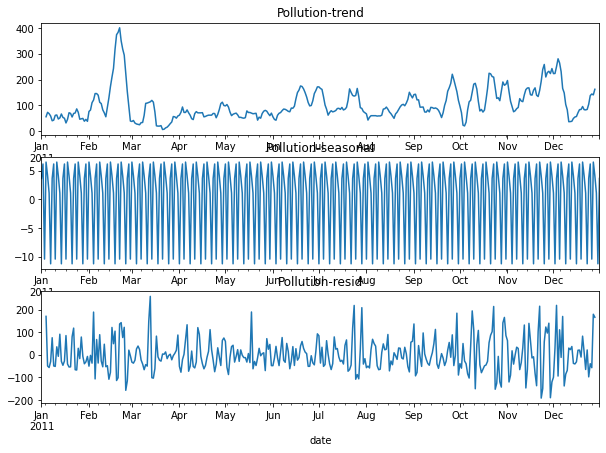

In [8]:
#### seasonal decompose = pollution
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['pollution'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("Pollution-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("Pollution-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("Pollution-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

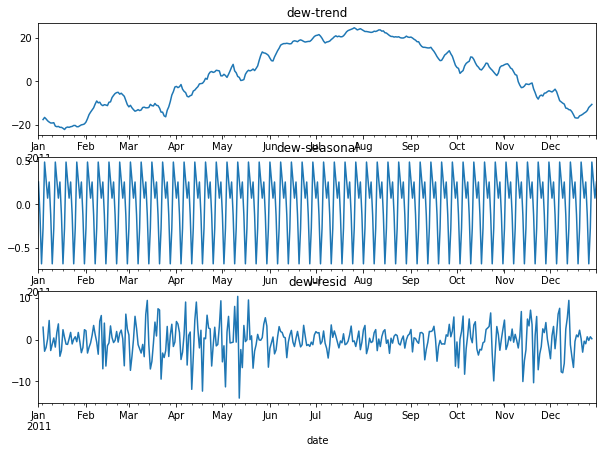

In [9]:
#### seasonal decompose = dew
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['dew'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("dew-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("dew-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("dew-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

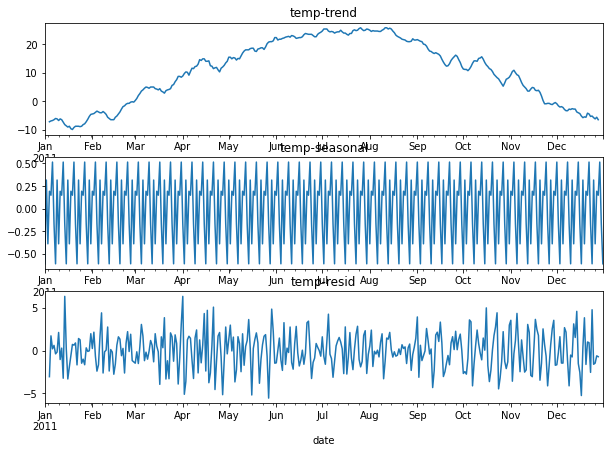

In [10]:
#### seasonal decompose = temp
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['temp'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("temp-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("temp-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("temp-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

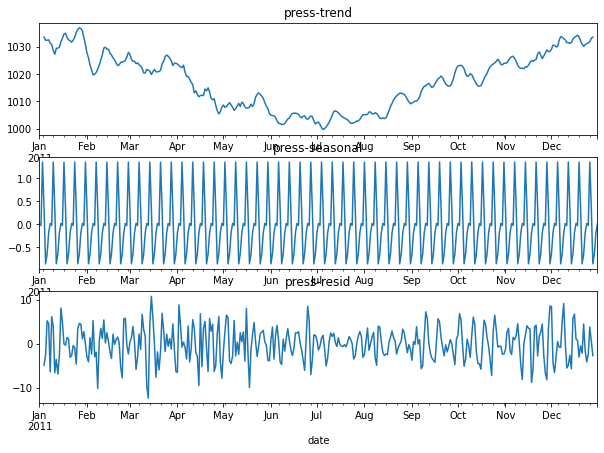

In [11]:
#### seasonal decompose = press
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['press'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("press-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("press-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("press-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

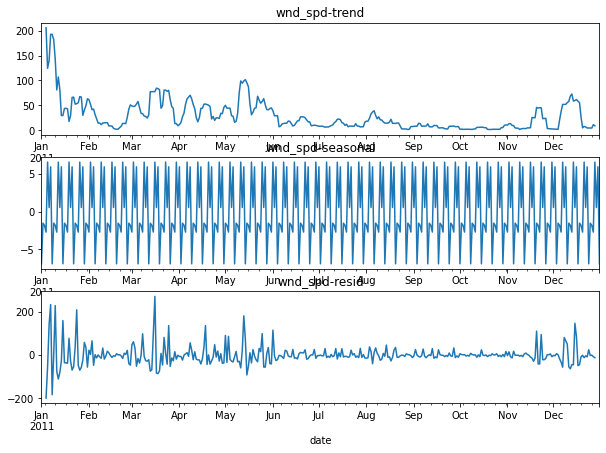

In [12]:
#### seasonal decompose = wnd_spd
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['wnd_spd'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("wnd_spd-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("wnd_spd-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("wnd_spd-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

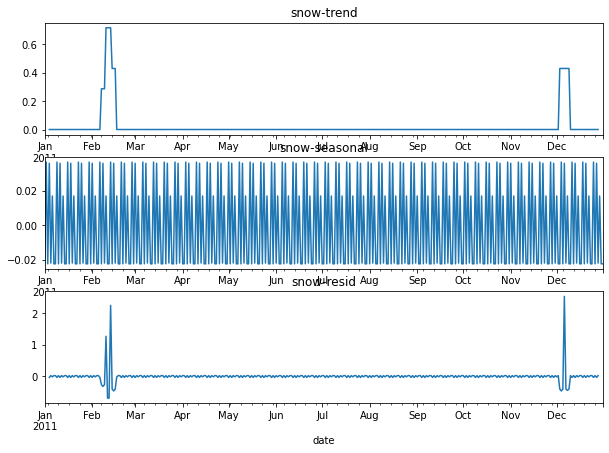

In [13]:
#### seasonal decompose = snow
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['snow'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("snow-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("snow-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("snow-resid")

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 720x504 with 0 Axes>

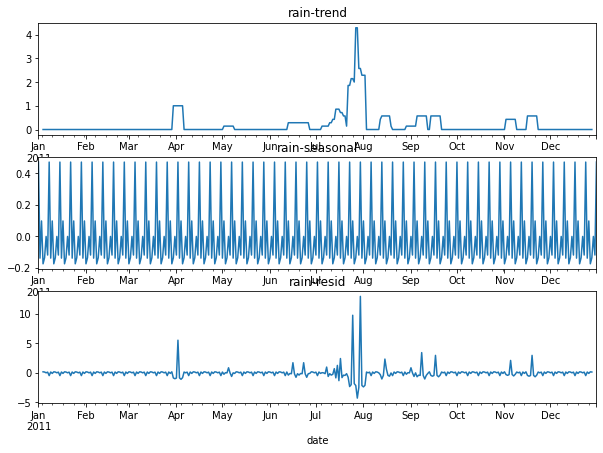

In [14]:
#### seasonal decompose = rain
plt.figure(figsize = (10,7))
air_results = seasonal_decompose(df_air_year_2011['rain'],model = 'add')

plt.figure(figsize = (10,7))
plt.subplot(311)
air_results.trend.plot()
plt.title("rain-trend")

plt.subplot(312)
air_results.seasonal.plot()
plt.title("rain-seasonal")

plt.subplot(313)
air_results.resid.plot()
plt.title("rain-resid")

plt.show()

In [15]:
#### considering only few parameters
df_air_filtered = df_air[['pollution','dew','temp','press','wnd_spd','rain']]
df_air_filtered.head()

,pollution,dew,temp,press,wnd_spd,rain
date,,,,,,
2010-01-02,129.0,-16,-4.0,1020.0,1.79,0
2010-01-03,90.0,-7,-6.0,1027.0,58.56,0
2010-01-04,79.0,-14,-12.0,1023.0,16.09,0
2010-01-05,30.0,-26,-17.0,1035.0,201.58,0
2010-01-06,56.0,-25,-17.0,1033.0,26.83,0


In [16]:
#### auto sarima for best pqd values
train1  = df_air_filtered[:-365]
test1 = df_air_filtered[-365:]
print(train1.shape,test1.shape)

exo_grid = auto_arima(df_air_filtered['pollution'],exogenous = df_air_filtered[['dew',
          'temp','press','wnd_spd','rain']],
          seasonal = True,m = 7, trace = True)
exo_grid.summary()

(1460, 6) (365, 6)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=21384.520, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=21659.243, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=21392.014, Time=1.22 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=21419.890, Time=1.54 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=21657.248, Time=0.44 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=21391.134, Time=2.04 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=21391.323, Time=1.88 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=21383.862, Time=3.49 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=21383.795, Time=3.32 sec
 ARIMA(1,0,2)(2,0,0)[7] intercept   : AIC=21223.915, Time=3.31 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=21196.985, Time=1.63 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=21182.147, Time=1.11 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=21202.517, Time=2.06 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.15 sec
 ARIMA

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1825
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -10581.073
Date:                Sat, 09 Jul 2022   AIC                          21182.147
Time:                        12:52:24   BIC                          21237.240
Sample:                    01-02-2010   HQIC                         21202.470
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4897      5.269      0.662      0.508      -6.837      13.817
dew            8.8805      0.464     19.137      0.000       7.971       9.790
temp          -2.2477      0.762     -2.950      0.003      -3.741      -0.755
press         -4.0944      0.474     -8.644      0.000      -5.023      -3.166
wnd_spd       -0.0933      0.051     -1.815      0.070      -0.194       0.007
rain          -5.7576      1.546     -3.724      0.000      -8.788      -2.728
ar.L1          0.9991      0.001    771.955      0.000       0.997       1.002
ma.L1         -0.6132      0.020    -30.281      0.000      -0.653      -0.573
ma.L2         -0.1795      0.022     -8.297      0.000      -0.222      -0.137
sigma2      6714.4274    178.272     37.664      0.000    6365.022    7063.833
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):               441.11
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.62
Prob(H) (two-sided):                  0.14   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

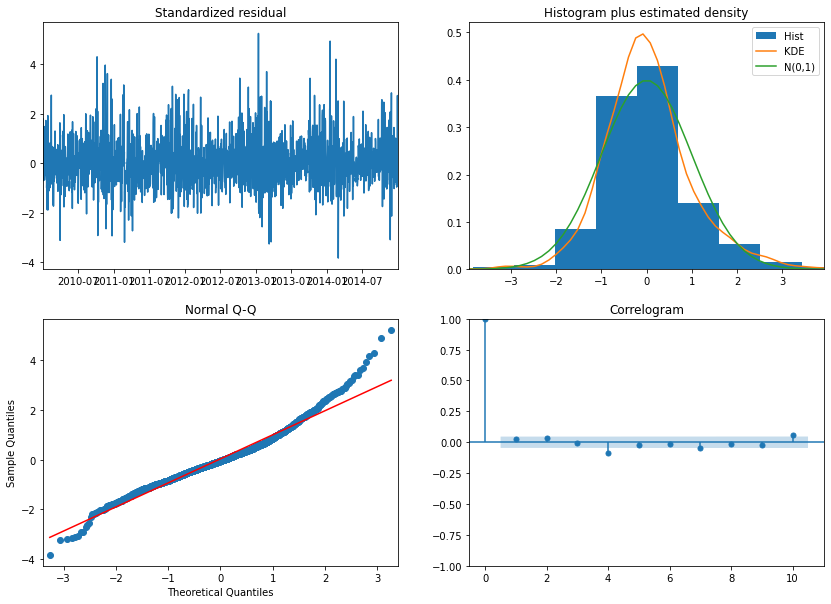

In [17]:
# Analysis of residues
exo_grid.plot_diagnostics(figsize=(14,10))
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dickey–Fuller test:: p=0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

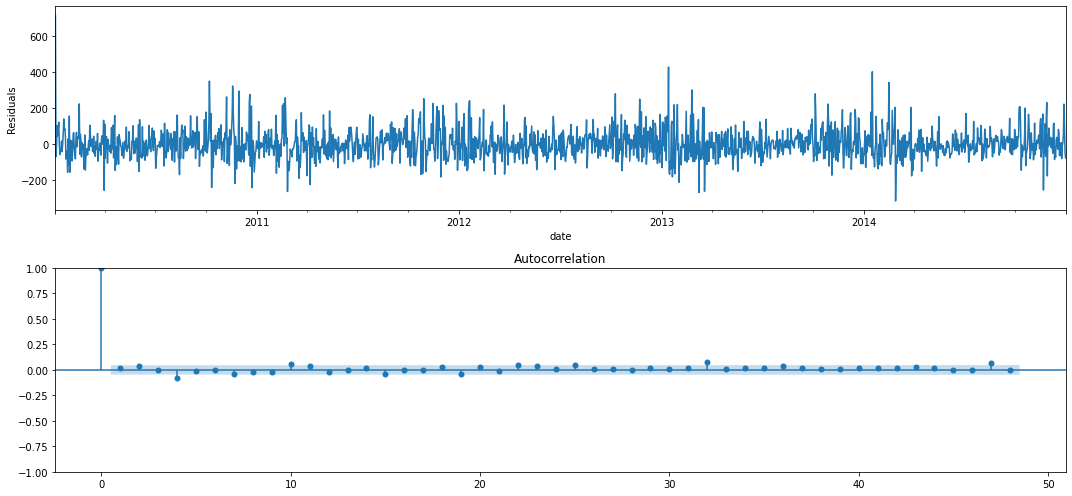

In [18]:
# Analysis of residues 2
plt.figure(figsize=(15,7))
plt.subplot(211)
exo_grid.resid().plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(exo_grid.resid(), lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(exo_grid.resid())[1])
plt.tight_layout()
plt.show()

In [26]:
#### SARIMAX
model = SARIMAX(df_air_filtered['pollution'],exog=df_air_filtered[[
          'temp','wnd_spd']],
                   order = (1,0,2), seasonal_order = (0,0,0,7)).fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.01564D+00    |proj g|=  1.66121D-01

At iterate    5    f=  5.96224D+00    |proj g|=  1.73376D-02

At iterate   10    f=  5.95224D+00    |proj g|=  1.47913D-02

At iterate   15    f=  5.94612D+00    |proj g|=  1.90994D-03


 This problem is unconstrained.



At iterate   20    f=  5.94093D+00    |proj g|=  1.16224D-03

At iterate   25    f=  5.93974D+00    |proj g|=  7.41397D-03

At iterate   30    f=  5.93967D+00    |proj g|=  1.86323D-04

At iterate   35    f=  5.93956D+00    |proj g|=  1.92980D-03

At iterate   40    f=  5.93948D+00    |proj g|=  1.62216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   9.012D-06   5.939D+00
  F =   5.9394760128769741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              pollution   No. Observations:                 1825
Model:               SARIMAX(1, 0, 2)   Log Likelihood              -10839.544
Date:                Sun, 10 Jul 2022   AIC                          21691.087
Time:                        16:15:17   BIC                          21724.143
Sample:                    01-02-2010   HQIC                         21703.281
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           1.4992      0.635      2.360      0.018       0.254       2.744
wnd_spd       -0.4350      0.051     -8.463      0.000      -0.536      -0.334
ar.L1          0.9984      0.002    612.323      0.000       0.995       1.002
ma.L1         -0.6008      0.019    -31.505      0.000      -0.638      -0.563
ma.L2         -0.3261      0.020    -16.444      0.000      -0.365      -0.287
sigma2      8431.9476    222.912     37.826      0.000    7995.049    8868.846
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               536.37
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.89
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Dickey–Fuller test:: p=0.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

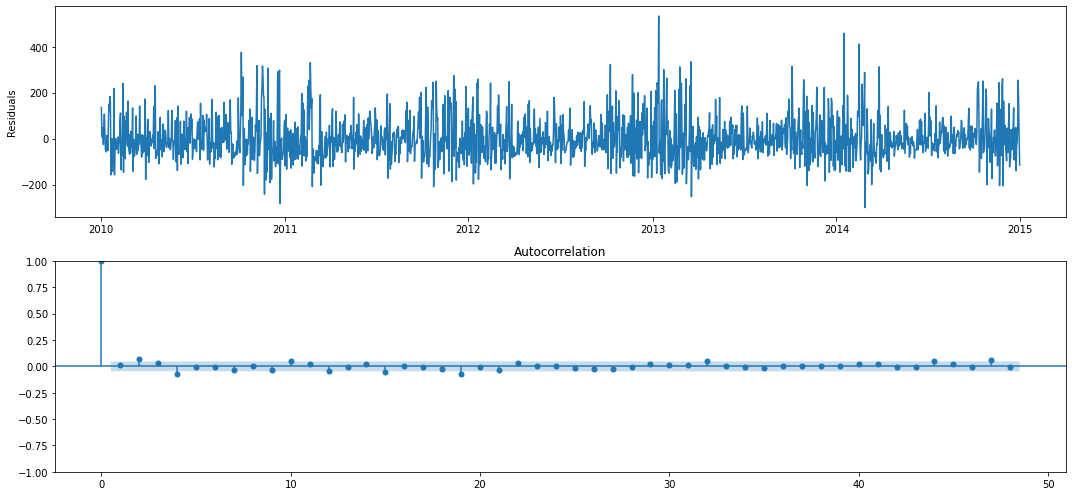

In [27]:
# Analysis of residues
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(model.resid)
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid, lags=48, ax=ax)
print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(model.resid)[1])
plt.tight_layout()
plt.show()

In [ ]:
df.merge()